In [39]:
import sys
sys.path.append("..")

import torch
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from datasets.backdoor_dataset import CIFAR10M,CustomDataset_224,CIFAR10Mem
import numpy as np
from datasets.bd_dataset_imagenet_filter import BadEncoderDataset
from torch import nn
torch.cuda.set_device(0)

def dataloader(dataset):
    batch_size=512
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        # transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(1, 1, 1, 0.5)], p=1),
        # transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
        ])

    clean_transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
                ])

    memory_data = CIFAR10M(numpy_file=f'../data/{dataset}/train.npz', class_type=classes, transform=train_transform,transform2=clean_transform)
    train_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_data = CIFAR10M(numpy_file=f'../data/{dataset}/test.npz', class_type=classes, transform=train_transform,transform2=clean_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    return train_loader,test_loader

In [40]:
from models import get_encoder_architecture_usage
import argparse

args=argparse.Namespace(
    pretrained_encoder='../output/cifar10/clean_encoder/model_1000.pth',
    encoder_usage_info='cifar10'
)

clean_model = get_encoder_architecture_usage(args).cuda()
checkpoint = torch.load(args.pretrained_encoder)
clean_model.load_state_dict(checkpoint['state_dict'])
clean_model.g.add_module('classifier', nn.Linear(in_features=128, out_features=2, bias=True))
clean_model=clean_model.cuda()

In [41]:
import torch.nn.functional as F
import os,random,copy
import kornia.augmentation as A

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score
import seaborn as sns


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 假定已经定义了model, wanet, train_loader和test_loader

class ProbTransform(torch.nn.Module):
    def __init__(self, f, p=1):
        super(ProbTransform, self).__init__()
        self.f = f
        self.p = p

    def forward(self, x):  # , **kwargs):
        if random.random() < self.p:
            return self.f(x)
        else:
            return x


class PostTensorTransform(torch.nn.Module):
    def __init__(self):
        super(PostTensorTransform, self).__init__()
        self.random_crop = ProbTransform(
            A.RandomCrop((32, 32), padding=5), p=0.8
        )
        self.random_rotation = ProbTransform(A.RandomRotation(10), p=0.5)


    def forward(self, x):
        for module in self.children():
            x = module(x)
        return x


def wanet(clean_img):
    input_height=32
    grid_rescale=1
    s=0.5
    k=4
    num_bd = clean_img.shape[0] // 2
    num_cross = num_bd
    ins = torch.rand(1, 2, k, k) * 2 - 1
    ins = ins / torch.mean(torch.abs(ins))
    noise_grid = (
        F.upsample(ins, size=input_height, mode="bicubic", align_corners=True)
        .permute(0, 2, 3, 1)
        .cuda()
    )
    array1d = torch.linspace(-1, 1, steps=input_height)
    x, y = torch.meshgrid(array1d, array1d)
    identity_grid = torch.stack((y, x), 2)[None, ...].cuda()

    grid_temps = (identity_grid + s * noise_grid / input_height) * grid_rescale
    grid_temps = torch.clamp(grid_temps, -1, 1)
    transforms = PostTensorTransform().cuda()

    ins = torch.rand(num_cross, input_height, input_height, 2).cuda() * 2 - 1
    grid_temps2 = grid_temps.repeat(num_cross, 1, 1, 1) + ins / input_height
    grid_temps2 = torch.clamp(grid_temps2, -1, 1)

    inputs_bd = F.grid_sample(clean_img[:num_bd], grid_temps.repeat(num_bd, 1, 1, 1), align_corners=True)

    inputs_cross = F.grid_sample(clean_img[num_bd : (num_bd + num_cross)], grid_temps2, align_corners=True)

    total_inputs = torch.cat([inputs_bd, inputs_cross], dim=0)
    backdoored_img = transforms(total_inputs)
    return backdoored_img





# # 加载预训练的ResNet50模型并修改最后一层以适应二分类任务
# model = models.resnet50(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)  # 二分类
# model = model.cuda()  # 确保模型在CUDA设备上

# # 定义损失函数（虽然在测试中可能不需要，除非你想计算损失）
# criterion = nn.CrossEntropyLoss()


# def train_and_test_model(model, train_loader, test_loader):
#     # 训练模式
#     # 定义损失函数和优化器
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     epochs=30

#     model.train()
#     for epoch in range(epochs):  # 多个周期
#         train_loss = 0.0
#         for clean_img, aug_img in tqdm(train_loader):
#             clean_img = clean_img.cuda()
#             aug_img = aug_img.cuda()
#             # 使用wanet处理clean_img
#             wanet_bd = wanet(clean_img)

#             # 准备输入数据和标签
#             inputs = torch.cat([wanet_bd, aug_img], dim=0)
#             labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
#             inputs, labels = inputs.cuda(), labels.cuda()

#             # 清零梯度
#             optimizer.zero_grad()

#             # 前向传播，反向传播，优化
#             outputs = model(inputs)
#             # print(outputs.shape)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item() * inputs.size(0)

#         print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader.dataset):.4f}')

#     # 测试模式
#     model.eval()
#     correct = 0
#     total = 0
#     test_loss = 0.0
#     y_true = []
#     y_pred = []
#     y_score = []

#     with torch.no_grad():
#         for clean_img, aug_img in tqdm(test_loader):
#             clean_img = clean_img.cuda()
#             aug_img = aug_img.cuda()
#             wanet_bd = wanet(clean_img)

#             inputs = torch.cat([wanet_bd, aug_img], dim=0)
#             labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
#             inputs, labels = inputs.cuda(), labels.cuda()

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item() * inputs.size(0)

#             _, predicted = torch.max(outputs, 1)
#             probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             y_true.extend(labels.cpu().numpy())
#             y_pred.extend(predicted.cpu().numpy())
#             y_score.extend(probs.cpu().numpy())

#     avg_loss = test_loss / total
#     accuracy = 100 * correct / total
#     f1 = f1_score(y_true, y_pred)
#     auroc = roc_auc_score(y_true, y_score)

#     print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}, AUROC: {auroc:.4f}')



def train_and_test_model_tsne(model, train_loader, test_loader):
    # 省略训练部分的代码...
    model.fc = nn.Identity()  # 移除最后一层
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs=1

    model.train()
    for epoch in range(epochs):  # 多个周期
        train_loss = 0.0
        for clean_img, aug_img in tqdm(train_loader):
            clean_img = clean_img.cuda()
            aug_img = aug_img.cuda()
            # 使用wanet处理clean_img
            wanet_bd = wanet(clean_img)

            # 准备输入数据和标签
            inputs = torch.cat([wanet_bd, aug_img], dim=0)
            labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 清零梯度
            optimizer.zero_grad()
            # print(inputs.shape)

            # 前向传播，反向传播，优化
            outputs = model(inputs)
            # print(outputs)
            loss = criterion(outputs[0], labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader.dataset):.4f}')

    # 测试模式
    model.eval()
    features_list = []
    labels_list = []
    model.g.classifier = nn.Identity()  # 移除最后一层

    with torch.no_grad():
        for i,(clean_img, aug_img) in enumerate(tqdm(test_loader)):
            if i > 5:
                break
            clean_img = clean_img.cuda()
            aug_img = aug_img.cuda()
            wanet_bd = wanet(clean_img)

            inputs = torch.cat([wanet_bd, aug_img], dim=0)
            labels = torch.cat([torch.zeros(wanet_bd.size(0)), torch.ones(aug_img.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 使用模型的特征提取方法
            features = model(inputs)
            print(features[1].shape)
            features_list.append(features[1].cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            # 其余的测试代码，计算损失，准确率等...

    # 将features和labels_tsne转换为适合t-SNE的格式
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    # 使用t-SNE进行降维
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    # 可视化
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=labels,
        palette=sns.color_palette("hsv", 2),
        legend="full",
        alpha=0.8
    )
    plt.title('t-SNE visualization of model features')
    plt.show()
# 注意：此代码假设wanet函数和其他必要的模块已经定义并可以正常工作

  0%|          | 0/98 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 98/98 [00:37<00:00,  2.64it/s]


Epoch 1, Train Loss: 10.8807


  5%|▌         | 1/20 [00:01<00:22,  1.19s/it]

torch.Size([1024, 128])


 10%|█         | 2/20 [00:01<00:11,  1.51it/s]

torch.Size([1024, 128])


 15%|█▌        | 3/20 [00:01<00:09,  1.83it/s]

torch.Size([1024, 128])


 20%|██        | 4/20 [00:02<00:06,  2.31it/s]

torch.Size([1024, 128])


 25%|██▌       | 5/20 [00:02<00:06,  2.26it/s]

torch.Size([1024, 128])


 30%|███       | 6/20 [00:02<00:05,  2.59it/s]

torch.Size([1024, 128])


 30%|███       | 6/20 [00:04<00:10,  1.28it/s]


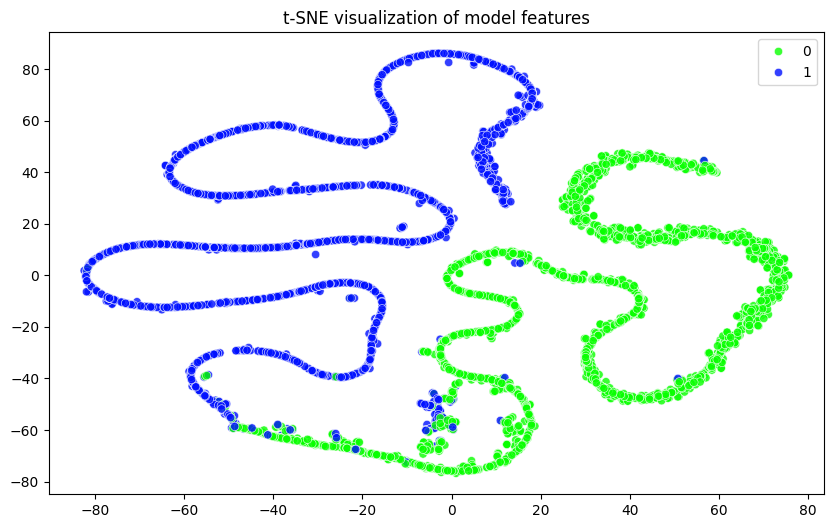

: 

In [42]:
train_loader,test_loader=dataloader('cifar10')
train_and_test_model_tsne(clean_model, train_loader, test_loader)

  0%|          | 0/10 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch 1, Train Loss: 10.5038


  6%|▋         | 1/16 [00:01<00:18,  1.21s/it]

torch.Size([1024, 128])


 12%|█▎        | 2/16 [00:01<00:08,  1.61it/s]

torch.Size([1024, 128])


 19%|█▉        | 3/16 [00:01<00:07,  1.74it/s]

torch.Size([1024, 128])


 25%|██▌       | 4/16 [00:02<00:05,  2.13it/s]

torch.Size([1024, 128])


 31%|███▏      | 5/16 [00:02<00:04,  2.25it/s]

torch.Size([1024, 128])


 38%|███▊      | 6/16 [00:02<00:03,  2.57it/s]

torch.Size([1024, 128])


 44%|████▍     | 7/16 [00:03<00:03,  2.57it/s]

torch.Size([1024, 128])


 50%|█████     | 8/16 [00:03<00:02,  2.85it/s]

torch.Size([1024, 128])


 56%|█████▋    | 9/16 [00:04<00:02,  2.65it/s]

torch.Size([1024, 128])


 62%|██████▎   | 10/16 [00:04<00:02,  2.86it/s]

torch.Size([1024, 128])


 69%|██████▉   | 11/16 [00:04<00:01,  2.68it/s]

torch.Size([1024, 128])


 75%|███████▌  | 12/16 [00:04<00:01,  3.06it/s]

torch.Size([1024, 128])


 81%|████████▏ | 13/16 [00:05<00:01,  2.74it/s]

torch.Size([1024, 128])


 88%|████████▊ | 14/16 [00:05<00:00,  2.67it/s]

torch.Size([1024, 128])


 94%|█████████▍| 15/16 [00:06<00:00,  2.88it/s]

torch.Size([1024, 128])
torch.Size([640, 128])


100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


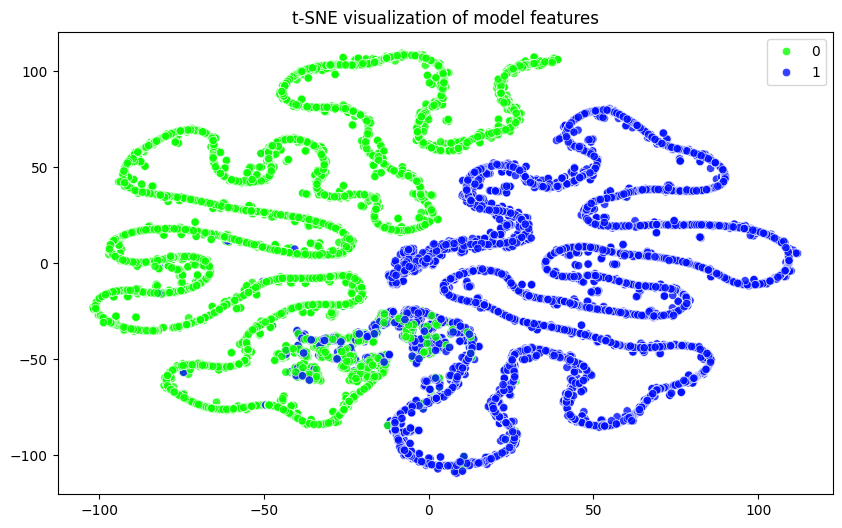

In [24]:
train_loader,test_loader=dataloader('stl10')
train_and_test_model_tsne(clean_model, train_loader, test_loader)

In [25]:
train_loader,test_loader=dataloader('svhn')
train_and_test_model_tsne(clean_model, train_loader, test_loader)

  0%|          | 0/144 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 144/144 [00:51<00:00,  2.81it/s]


Epoch 1, Train Loss: 10.5102


  4%|▍         | 2/51 [00:01<00:29,  1.66it/s]

torch.Size([1024, 128])
torch.Size([1024, 128])


  8%|▊         | 4/51 [00:02<00:19,  2.43it/s]

torch.Size([1024, 128])
torch.Size([1024, 128])


 12%|█▏        | 6/51 [00:02<00:15,  2.91it/s]

torch.Size([1024, 128])
torch.Size([1024, 128])


 16%|█▌        | 8/51 [00:03<00:13,  3.13it/s]

torch.Size([1024, 128])
torch.Size([1024, 128])


 20%|█▉        | 10/51 [00:04<00:12,  3.20it/s]

torch.Size([1024, 128])
torch.Size([1024, 128])


 24%|██▎       | 12/51 [00:04<00:11,  3.31it/s]

torch.Size([1024, 128])
torch.Size([1024, 128])


 27%|██▋       | 14/51 [00:05<00:11,  3.19it/s]

torch.Size([1024, 128])
torch.Size([1024, 128])


 29%|██▉       | 15/51 [00:06<00:13,  2.60it/s]

torch.Size([1024, 128])
torch.Size([1024, 128])


 35%|███▌      | 18/51 [00:06<00:09,  3.40it/s]

torch.Size([1024, 128])
torch.Size([1024, 128])


 35%|███▌      | 18/51 [00:06<00:12,  2.59it/s]


KeyboardInterrupt: 

  0%|          | 0/77 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 77/77 [00:19<00:00,  3.94it/s]


Epoch 1, Train Loss: 10.5038


  8%|▊         | 2/25 [00:00<00:08,  2.68it/s]

torch.Size([1024, 512])
torch.Size([1024, 512])


 16%|█▌        | 4/25 [00:01<00:05,  3.68it/s]

torch.Size([1024, 512])
torch.Size([1024, 512])


 24%|██▍       | 6/25 [00:01<00:04,  4.20it/s]

torch.Size([1024, 512])
torch.Size([1024, 512])


 28%|██▊       | 7/25 [00:02<00:04,  3.62it/s]

torch.Size([1024, 512])
torch.Size([1024, 512])


 40%|████      | 10/25 [00:02<00:03,  4.60it/s]

torch.Size([1024, 512])
torch.Size([1024, 512])


 48%|████▊     | 12/25 [00:03<00:02,  4.57it/s]

torch.Size([1024, 512])
torch.Size([1024, 512])


 56%|█████▌    | 14/25 [00:03<00:02,  4.59it/s]

torch.Size([1024, 512])
torch.Size([1024, 512])


 64%|██████▍   | 16/25 [00:04<00:01,  4.52it/s]

torch.Size([1024, 512])
torch.Size([1024, 512])


 72%|███████▏  | 18/25 [00:04<00:01,  4.77it/s]

torch.Size([1024, 512])
torch.Size([1024, 512])


 80%|████████  | 20/25 [00:05<00:01,  4.18it/s]

torch.Size([1024, 512])
torch.Size([1024, 512])


 88%|████████▊ | 22/25 [00:05<00:00,  4.34it/s]

torch.Size([1024, 512])
torch.Size([1024, 512])


 96%|█████████▌| 24/25 [00:06<00:00,  4.49it/s]

torch.Size([1024, 512])
torch.Size([1024, 512])


100%|██████████| 25/25 [00:06<00:00,  3.84it/s]

torch.Size([684, 512])


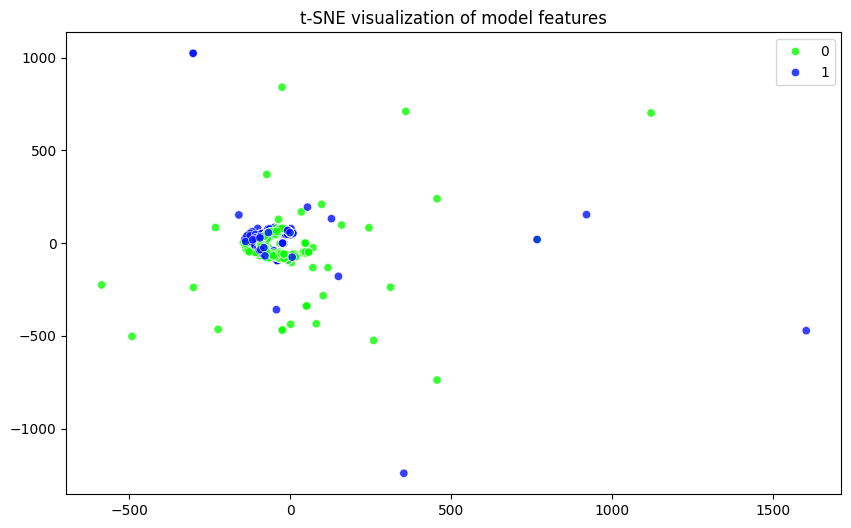

In [ ]:
train_loader,test_loader=dataloader('gtsrb')
train_and_test_model_tsne(clean_model, train_loader, test_loader)

In [11]:
train_loader,test_loader=dataloader('stl10')
train_and_test_model(model, train_loader,test_loader)

  0%|          | 0/1 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


Epoch 1, Train Loss: 1.5562


100%|██████████| 1/1 [00:05<00:00,  5.99s/it]


Epoch 2, Train Loss: 6.6296


100%|██████████| 1/1 [00:06<00:00,  6.04s/it]


Epoch 3, Train Loss: 1.6676


100%|██████████| 1/1 [00:05<00:00,  5.78s/it]


Epoch 4, Train Loss: 1.3253


100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


Epoch 5, Train Loss: 1.2597


100%|██████████| 1/1 [00:05<00:00,  5.84s/it]


Epoch 6, Train Loss: 1.2310


100%|██████████| 1/1 [00:05<00:00,  5.93s/it]


Epoch 7, Train Loss: 0.9630


100%|██████████| 1/1 [00:05<00:00,  5.55s/it]


Epoch 8, Train Loss: 0.9351


100%|██████████| 1/1 [00:05<00:00,  5.95s/it]


Epoch 9, Train Loss: 0.7284


100%|██████████| 1/1 [00:06<00:00,  6.10s/it]


Epoch 10, Train Loss: 0.6252


100%|██████████| 1/1 [00:05<00:00,  5.97s/it]


Epoch 11, Train Loss: 0.5497


100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


Epoch 12, Train Loss: 0.8518


100%|██████████| 1/1 [00:06<00:00,  6.03s/it]


Epoch 13, Train Loss: 0.3502


100%|██████████| 1/1 [00:05<00:00,  5.97s/it]


Epoch 14, Train Loss: 0.3217


100%|██████████| 1/1 [00:05<00:00,  5.91s/it]


Epoch 15, Train Loss: 0.4351


100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


Epoch 16, Train Loss: 0.4024


100%|██████████| 1/1 [00:06<00:00,  6.08s/it]


Epoch 17, Train Loss: 0.3801


100%|██████████| 1/1 [00:05<00:00,  5.67s/it]


Epoch 18, Train Loss: 0.6394


100%|██████████| 1/1 [00:06<00:00,  6.18s/it]


Epoch 19, Train Loss: 0.2871


100%|██████████| 1/1 [00:05<00:00,  5.77s/it]


Epoch 20, Train Loss: 0.5233


100%|██████████| 1/1 [00:05<00:00,  5.88s/it]


Epoch 21, Train Loss: 0.5829


100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


Epoch 22, Train Loss: 0.2488


100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


Epoch 23, Train Loss: 0.3204


100%|██████████| 1/1 [00:06<00:00,  6.14s/it]


Epoch 24, Train Loss: 0.2822


100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


Epoch 25, Train Loss: 0.2175


100%|██████████| 1/1 [00:05<00:00,  5.74s/it]


Epoch 26, Train Loss: 0.5007


100%|██████████| 1/1 [00:06<00:00,  6.17s/it]


Epoch 27, Train Loss: 0.2444


100%|██████████| 1/1 [00:06<00:00,  6.32s/it]


Epoch 28, Train Loss: 0.2414


100%|██████████| 1/1 [00:05<00:00,  5.83s/it]


Epoch 29, Train Loss: 0.1625


100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


Epoch 30, Train Loss: 0.5096


100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

Test Loss: 0.0910, Accuracy: 96.48%, F1 Score: 0.9644, AUROC: 0.9954


In [12]:
train_loader,test_loader=dataloader('svhn')
train_and_test_model(model, train_loader,test_loader)

  0%|          | 0/15 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


Epoch 1, Train Loss: 0.4302


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


Epoch 2, Train Loss: 0.2261


100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


Epoch 3, Train Loss: 0.1368


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch 4, Train Loss: 0.1442


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


Epoch 5, Train Loss: 0.1587


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch 6, Train Loss: 0.1137


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch 7, Train Loss: 0.1057


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


Epoch 8, Train Loss: 0.1714


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch 9, Train Loss: 0.0872


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


Epoch 10, Train Loss: 0.0676


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch 11, Train Loss: 0.0604


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch 12, Train Loss: 0.0807


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch 13, Train Loss: 0.1608


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Epoch 14, Train Loss: 0.0790


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Epoch 15, Train Loss: 0.0976


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Epoch 16, Train Loss: 0.1317


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


Epoch 17, Train Loss: 0.0810


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch 18, Train Loss: 0.0905


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Epoch 19, Train Loss: 0.0788


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch 20, Train Loss: 0.1239


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch 21, Train Loss: 0.0587


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


Epoch 22, Train Loss: 0.0971


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch 23, Train Loss: 0.0687


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch 24, Train Loss: 0.0950


100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


Epoch 25, Train Loss: 0.0536


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


Epoch 26, Train Loss: 0.0779


100%|██████████| 15/15 [00:35<00:00,  2.37s/it]


Epoch 27, Train Loss: 0.0622


100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch 28, Train Loss: 0.0442


100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


Epoch 29, Train Loss: 0.0485


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


Epoch 30, Train Loss: 0.0584


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]

Test Loss: 0.1737, Accuracy: 94.06%, F1 Score: 0.9439, AUROC: 0.9951


In [13]:
train_loader,test_loader=dataloader('gtsrb')
train_and_test_model(model, train_loader,test_loader)

  0%|          | 0/8 [00:00<?, ?it/s]/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


Epoch 1, Train Loss: 0.3242


100%|██████████| 8/8 [00:20<00:00,  2.59s/it]


Epoch 2, Train Loss: 0.2396


100%|██████████| 8/8 [00:21<00:00,  2.66s/it]


Epoch 3, Train Loss: 0.1226


100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


Epoch 4, Train Loss: 0.1177


100%|██████████| 8/8 [00:20<00:00,  2.61s/it]


Epoch 5, Train Loss: 0.1102


100%|██████████| 8/8 [00:20<00:00,  2.54s/it]


Epoch 6, Train Loss: 0.0951


100%|██████████| 8/8 [00:21<00:00,  2.67s/it]


Epoch 7, Train Loss: 0.0474


100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


Epoch 8, Train Loss: 0.0196


100%|██████████| 8/8 [00:20<00:00,  2.60s/it]


Epoch 9, Train Loss: 0.0590


100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


Epoch 10, Train Loss: 0.0634


100%|██████████| 8/8 [00:20<00:00,  2.58s/it]


Epoch 11, Train Loss: 0.0538


100%|██████████| 8/8 [00:21<00:00,  2.63s/it]


Epoch 12, Train Loss: 0.0409


100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


Epoch 13, Train Loss: 0.0425


100%|██████████| 8/8 [00:21<00:00,  2.67s/it]


Epoch 14, Train Loss: 0.0538


100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


Epoch 15, Train Loss: 0.0550


100%|██████████| 8/8 [00:20<00:00,  2.58s/it]


Epoch 16, Train Loss: 0.0571


100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


Epoch 17, Train Loss: 0.0269


100%|██████████| 8/8 [00:20<00:00,  2.61s/it]


Epoch 18, Train Loss: 0.0287


100%|██████████| 8/8 [00:20<00:00,  2.59s/it]


Epoch 19, Train Loss: 0.0361


100%|██████████| 8/8 [00:21<00:00,  2.63s/it]


Epoch 20, Train Loss: 0.0333


100%|██████████| 8/8 [00:20<00:00,  2.55s/it]


Epoch 21, Train Loss: 0.0289


100%|██████████| 8/8 [00:21<00:00,  2.63s/it]


Epoch 22, Train Loss: 0.0279


100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


Epoch 23, Train Loss: 0.0451


100%|██████████| 8/8 [00:20<00:00,  2.54s/it]


Epoch 24, Train Loss: 0.0514


100%|██████████| 8/8 [00:20<00:00,  2.59s/it]


Epoch 25, Train Loss: 0.0613


100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


Epoch 26, Train Loss: 0.0432


100%|██████████| 8/8 [00:20<00:00,  2.55s/it]


Epoch 27, Train Loss: 0.0356


100%|██████████| 8/8 [00:20<00:00,  2.57s/it]


Epoch 28, Train Loss: 0.0337


100%|██████████| 8/8 [00:20<00:00,  2.59s/it]


Epoch 29, Train Loss: 0.0140


100%|██████████| 8/8 [00:20<00:00,  2.61s/it]


Epoch 30, Train Loss: 0.0517


100%|██████████| 3/3 [00:07<00:00,  2.57s/it]

Test Loss: 0.0127, Accuracy: 99.53%, F1 Score: 0.9953, AUROC: 0.9999
